In [1]:
from time import perf_counter
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Small gas container example

Run this notebook straight down to generate some data reported in the paper.  

In [2]:
# Simulation parameters
N = 4
gamma = 8

# Compute L,M matrices
L = np.zeros((N,N))
L[:2,:2] = np.array([[0,1],[-1,0]])

def E1(x,q):
    return (np.exp(x)/q)**(2/3)

def E2(x,q):
    return (np.exp(x)/(2-q))**(2/3)

def EE(y):
    q,p,S1,S2 = y
    return 1/2*p**2 + E1(S1,q) + E2(S2,q)

def M(t,y):
    q,p,S1,S2 = y
    mtx = np.zeros((N,N))
    T1 = 2/3*E1(S1,q)
    T2 = 2/3*E2(S2,q)
    
    mtx[-2:,-2:] = gamma * np.array([[T1**(-2), -1/(T1*T2)],
                                     [-1/(T1*T2), T2**(-2)]])
    return mtx

# This function stores w^\alpha in A^\alpha = w^\alpha \wedge e[2]
def Mvec(t,y):
    q,p,S1,S2 = y
    T1 = 2/3*E1(S1,q)
    T2 = 2/3*E2(S2,q)
    vec = np.zeros(N)
    vec[2] = np.sqrt(gamma)/T1
    vec[3] = -np.sqrt(gamma)/T2
    return vec/T1

# Compute gradients
def gradE(t,y):
    comp1 = -2/3*((np.exp(2*y[2])/y[0]**5)**(1/3) \
                  - (np.exp(2*y[3])/(2-y[0])**5)**(1/3))
    comp2 = y[1]
    comp3 = 2/3*E1(y[2],y[0])
    comp4 = 2/3*E2(y[3],y[0])
    return np.stack((comp1,comp2,comp3,comp4), axis=0)
    
gradS = np.array([0,0,1,1])

# FOM in vector and matrix form
def FOrhs(t,y):
    q,p,S1,S2 = y
    T1 = 2/3*E1(S1,q)
    T2 = 2/3*E2(S2,q)    
    out = np.zeros(N)
    out[0] = p
    out[1] = T1/q - T2/(2-q)
    out[2] = gamma/T1*(1/T1 - 1/T2)
    out[3] = -gamma/T2*(1/T1 - 1/T2)
    return out
    
def FOrhsM(t,y): return L @ gradE(t,y) + M(t,y) @ gradS

## Setting up the ROM

This block computes the POD basis and defines the ROM functions.

In [3]:
# np.random.seed(4)
np.random.seed(3)

n = 3  #reduced dim
T = 8  #training time

# Generate training parameters
l = np.array([0.2,-1,1,1])
u = np.array([1.8,1,3,3])
x = np.random.rand(50,4)
ics = x*l + (1-x)*u

# Generating snapshots
tt = np.arange(0,T,0.005)  #training t-range
snapsL=[]
for ic in ics:
    soln = solve_ivp(FOrhs, (0,T), ic, method='LSODA', 
                     dense_output=True, atol=1e-14, rtol=1e-14)
    snapsL.append(soln.sol(tt) - ic.reshape(-1,1))
    snapsL.append(1*gradE(0,soln.sol(tt)))
snapsL.append(1*gradS)
snaps = snapsL[0]
for i in range(len(snapsL)-1):
    snaps = np.concatenate((snaps,snapsL[i]), axis=1)
 
# Computing reduced basis
Ubig,S,_ = np.linalg.svd(snaps, full_matrices=False)
U = Ubig[:,:n]
print(f'energy distribution is {S / np.sum(S) * 100}')

# Computing LtensR and reduced gradS
gradSr = U.T @ gradS
Lr = U.T @ L @ U
Lhgs = Lr @ U.T @ gradS
# Assuming gradS[-1] = 1...
Lmat = np.tensordot(U[-1],Lhgs,0) - np.tensordot(Lhgs,U[-1],0) + np.dot(U[-1],gradSr)*Lr

# Compute ROM rhs
def ROrhsM(t,y,ic):
    gradEr = U.T @ gradE(t,ic+U@y)
    wHat = U.T @ Mvec(t,ic+U@y)
    v = np.dot(U[2],gradEr)*wHat - np.dot(wHat,gradEr)*U[2]
    return Lmat @ gradEr + np.dot(v,gradSr)*v

# Computing other ROMs for comparison
mPt = U @ U.T @ gradS
lPt = U.T @ L @ U @ U.T
def ROrhsOld(t,y,ic): 
    return lPt @ gradE(t,ic+U@y) + U.T @ M(t,ic+U@y) @ mPt

LL = U.T @ L
def ROrhsNoSP(t,y,ic):
    return LL @ gradE(t,ic+U@y) + U.T @ M(t,ic+U@y) @ gradS

/Users/agrubertx/miniconda3/envs/new38/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:46: UserWarning: `rtol` is too low, setting to 2.220446049250313e-14
  warn("`rtol` is too low, setting to {}".format(100 * EPS))


energy distribution is [45.30089672 36.9320396  12.36734867  5.399715  ]


## Solving the ROM

Also plotting the comparison for n=2,3,4.  (This part is hard coded and ugly.)

Final integration time can be changed between T=8,32 (or whatever you want).

n is 2
time of FOM is 0.07443983299999957
time of new ROM is 0.012537334000000122
time of old ROM is 0.014426499999999898
time of no-SP ROM is 0.024732292000000378
relative errors are 0.15839669699604705 (new), 0.16002170108169014 (old), 0.5895946458990585 (no)
max errors are 0.9165908155572464 (new), 0.9161783392955013 (old), 2.436366928103129 (no)
no S max errors are 0.9165908155572464 (new), 0.9161783392955013 (old), 0.9171776616929448 (no)
n is 3
time of FOM is 0.07756691699999951
time of new ROM is 0.1046012919999999
time of old ROM is 0.06357120900000002
time of no-SP ROM is 0.06328295899999947
relative errors are 0.0746271381239368 (new), 0.07302647762012963 (old), 0.06808466981760264 (no)
max errors are 0.23381678151125532 (new), 0.22458749123294597 (old), 0.22442735698526262 (no)
no S max errors are 0.23381678151125532 (new), 0.19989870355160996 (old), 0.14750093838277709 (no)
n is 4
time of FOM is 0.08029675000000047
time of new ROM is 0.06827333399999969
time of old ROM is 0

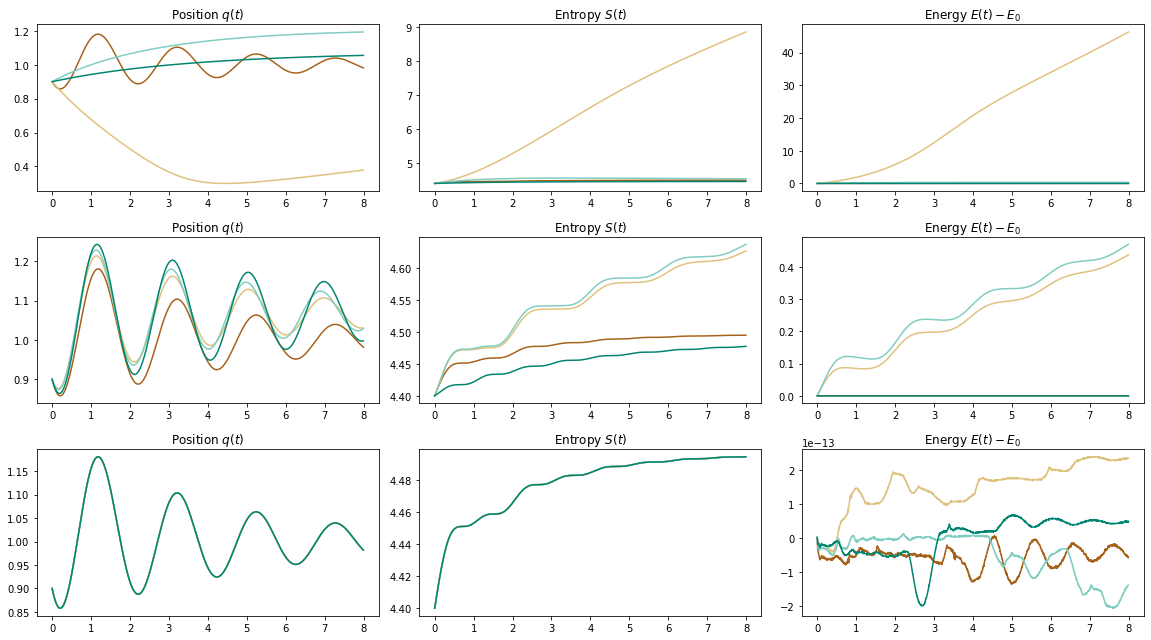

In [4]:
np.random.seed(3)
T=8
tt = np.arange(0,T,0.005)  #testing t-range
ic = np.array([0.9, -0.4, 2.4, 2.0])

################ n=2 ##################

# Computing reduced basis
n = 2
U = Ubig[:,:n]

print(f'n is {n}')

# Computing LtensR and reduced gradS
gradSr = U.T @ gradS
Lr = U.T @ L @ U
Lhgs = Lr @ U.T @ gradS
# Assuming gradS[-1] = 1...
Lmat = np.tensordot(U[-1],Lhgs,0) - np.tensordot(Lhgs,U[-1],0) + np.dot(U[-1],gradSr)*Lr

mPt = U @ U.T @ gradS
lPt = U.T @ L @ U @ U.T
LL = U.T @ L

start = perf_counter()
sol1 = solve_ivp(FOrhsM, (0,T), ic, method='LSODA',
                 dense_output=True, atol=1e-14, rtol=1e-14)
end = perf_counter()
print(f'time of FOM is {end-start}')

start = perf_counter()
solNew = solve_ivp(lambda t,y: ROrhsM(t,y,ic), (0,T), np.zeros(U.shape[1]),
                 method='LSODA', dense_output=True, atol=1e-14, rtol=1e-14)
end = perf_counter()
print(f'time of new ROM is {end-start}')

start = perf_counter()
solOld = solve_ivp(lambda t,y: ROrhsOld(t,y,ic), (0,T), np.zeros(U.shape[1]),
                 method='LSODA', dense_output=True, atol=1e-14, rtol=1e-14)
end = perf_counter()
print(f'time of old ROM is {end-start}')

start = perf_counter()
solNo = solve_ivp(lambda t,y: ROrhsNoSP(t,y,ic), (0,T), np.zeros(U.shape[1]),
                 method='LSODA', dense_output=True, atol=1e-14, rtol=1e-14)
end = perf_counter()
print(f'time of no-SP ROM is {end-start}')

ex2 = sol1.sol(tt)
recNew2 = ic.reshape(-1,1) + U @ solNew.sol(tt)
recOld2 = ic.reshape(-1,1) + U @ solOld.sol(tt)
recNo2 = ic.reshape(-1,1) + U @ solNo.sol(tt)

relEnew = np.linalg.norm(recNew2-ex2)/np.linalg.norm(ex2)
relEold = np.linalg.norm(recOld2-ex2)/np.linalg.norm(ex2) 
relEno = np.linalg.norm(recNo2-ex2)/np.linalg.norm(ex2) 

maxEnew = np.amax(np.sqrt((recNew2-ex2)*(recNew2-ex2)))
maxEold = np.amax(np.sqrt((recOld2-ex2)*(recOld2-ex2)))
maxEno = np.amax(np.sqrt((recNo2-ex2)*(recNo2-ex2)))

mxEnew = np.amax(np.sqrt((recNew2[:-2]-ex2[:-2])*(recNew2[:-2]-ex2[:-2])))
mxEold = np.amax(np.sqrt((recOld2[:-2]-ex2[:-2])*(recOld2[:-2]-ex2[:-2])))
mxEno = np.amax(np.sqrt((recNo2[:-2]-ex2[:-2])*(recNo2[:-2]-ex2[:-2])))

print(f'relative errors are {relEnew} (new), {relEold} (old), {relEno} (no)')
print(f'max errors are {maxEnew} (new), {maxEold} (old), {maxEno} (no)')
print(f'no S max errors are {mxEnew} (new), {mxEold} (old), {mxEno} (no)')

################ n=3 ##################

# Computing reduced basis
n = 3
U = Ubig[:,:n]

print(f'n is {n}')

# Computing LtensR and reduced gradS
gradSr = U.T @ gradS
Lr = U.T @ L @ U
Lhgs = Lr @ U.T @ gradS
# Assuming gradS[-1] = 1...
Lmat = np.tensordot(U[-1],Lhgs,0) - np.tensordot(Lhgs,U[-1],0) + np.dot(U[-1],gradSr)*Lr

mPt = U @ U.T @ gradS
lPt = U.T @ L @ U @ U.T
LL = U.T @ L

start = perf_counter()
sol1 = solve_ivp(FOrhsM, (0,T), ic, method='LSODA',
                 dense_output=True, atol=1e-14, rtol=1e-14)
end = perf_counter()
print(f'time of FOM is {end-start}')

start = perf_counter()
solNew = solve_ivp(lambda t,y: ROrhsM(t,y,ic), (0,T), np.zeros(U.shape[1]),
                 method='LSODA', dense_output=True, atol=1e-14, rtol=1e-14)
end = perf_counter()
print(f'time of new ROM is {end-start}')

start = perf_counter()
solOld = solve_ivp(lambda t,y: ROrhsOld(t,y,ic), (0,T), np.zeros(U.shape[1]),
                 method='LSODA', dense_output=True, atol=1e-14, rtol=1e-14)
end = perf_counter()
print(f'time of old ROM is {end-start}')

start = perf_counter()
solNo = solve_ivp(lambda t,y: ROrhsNoSP(t,y,ic), (0,T), np.zeros(U.shape[1]),
                 method='LSODA', dense_output=True, atol=1e-14, rtol=1e-14)
end = perf_counter()
print(f'time of no-SP ROM is {end-start}')

ex3 = sol1.sol(tt)
recNew3 = ic.reshape(-1,1) + U @ solNew.sol(tt)
recOld3 = ic.reshape(-1,1) + U @ solOld.sol(tt)
recNo3 = ic.reshape(-1,1) + U @ solNo.sol(tt)

relEnew = np.linalg.norm(recNew3-ex3)/np.linalg.norm(ex3)
relEold = np.linalg.norm(recOld3-ex3)/np.linalg.norm(ex3) 
relEno = np.linalg.norm(recNo3-ex3)/np.linalg.norm(ex3) 

maxEnew = np.amax(np.sqrt((recNew3-ex3)*(recNew3-ex3)))
maxEold = np.amax(np.sqrt((recOld3-ex3)*(recOld3-ex3)))
maxEno = np.amax(np.sqrt((recNo3-ex3)*(recNo3-ex3)))

mxEnew = np.amax(np.sqrt((recNew3[:-2]-ex3[:-2])*(recNew3[:-2]-ex3[:-2])))
mxEold = np.amax(np.sqrt((recOld3[:-2]-ex3[:-2])*(recOld3[:-2]-ex3[:-2])))
mxEno = np.amax(np.sqrt((recNo3[:-2]-ex3[:-2])*(recNo3[:-2]-ex3[:-2])))

print(f'relative errors are {relEnew} (new), {relEold} (old), {relEno} (no)')
print(f'max errors are {maxEnew} (new), {maxEold} (old), {maxEno} (no)')
print(f'no S max errors are {mxEnew} (new), {mxEold} (old), {mxEno} (no)')

################ n=4 ##################

# Computing reduced basis
n = 4
U = Ubig[:,:n]

print(f'n is {n}')

# Computing LtensR and reduced gradS
gradSr = U.T @ gradS
Lr = U.T @ L @ U
Lhgs = Lr @ U.T @ gradS
# Assuming gradS[-1] = 1...
Lmat = np.tensordot(U[-1],Lhgs,0) - np.tensordot(Lhgs,U[-1],0) + np.dot(U[-1],gradSr)*Lr

mPt = U @ U.T @ gradS
lPt = U.T @ L @ U @ U.T
LL = U.T @ L

start = perf_counter()
sol1 = solve_ivp(FOrhsM, (0,T), ic, method='LSODA',
                 dense_output=True, atol=1e-14, rtol=1e-14)
end = perf_counter()
print(f'time of FOM is {end-start}')

start = perf_counter()
solNew = solve_ivp(lambda t,y: ROrhsM(t,y,ic), (0,T), np.zeros(U.shape[1]),
                 method='LSODA', dense_output=True, atol=1e-14, rtol=1e-14)
end = perf_counter()
print(f'time of new ROM is {end-start}')

start = perf_counter()
solOld = solve_ivp(lambda t,y: ROrhsOld(t,y,ic), (0,T), np.zeros(U.shape[1]),
                 method='LSODA', dense_output=True, atol=1e-14, rtol=1e-14)
end = perf_counter()
print(f'time of old ROM is {end-start}')

start = perf_counter()
solNo = solve_ivp(lambda t,y: ROrhsNoSP(t,y,ic), (0,T), np.zeros(U.shape[1]),
                 method='LSODA', dense_output=True, atol=1e-14, rtol=1e-14)
end = perf_counter()
print(f'time of no-SP ROM is {end-start}')

ex4 = sol1.sol(tt)
recNew4 = ic.reshape(-1,1) + U @ solNew.sol(tt)
recOld4 = ic.reshape(-1,1) + U @ solOld.sol(tt)
recNo4 = ic.reshape(-1,1) + U @ solNo.sol(tt)

relEnew = np.linalg.norm(recNew4-ex4)/np.linalg.norm(ex4)
relEold = np.linalg.norm(recOld4-ex4)/np.linalg.norm(ex4) 
relEno = np.linalg.norm(recNo4-ex4)/np.linalg.norm(ex4) 

maxEnew = np.amax(np.sqrt((recNew4-ex4)*(recNew4-ex4)))
maxEold = np.amax(np.sqrt((recOld4-ex4)*(recOld4-ex4)))
maxEno = np.amax(np.sqrt((recNo4-ex4)*(recNo4-ex4)))

mxEnew = np.amax(np.sqrt((recNew4[:-2]-ex4[:-2])*(recNew4[:-2]-ex4[:-2])))
mxEold = np.amax(np.sqrt((recOld4[:-2]-ex4[:-2])*(recOld4[:-2]-ex4[:-2])))
mxEno = np.amax(np.sqrt((recNo4[:-2]-ex4[:-2])*(recNo4[:-2]-ex4[:-2])))

print(f'relative errors are {relEnew} (new), {relEold} (old), {relEno} (no)')
print(f'max errors are {maxEnew} (new), {maxEold} (old), {maxEno} (no)')
print(f'no S max errors are {mxEnew} (new), {mxEold} (old), {mxEno} (no)')

############### PLotting ################
ugh2 = EE(ex2[:,0])
ugh3 = EE(ex3[:,0])
ugh4 = EE(ex4[:,0])
Eex2 = EE(ex2) - ugh2
Eex3 = EE(ex3) - ugh3
Eex4 = EE(ex4) - ugh4
Enew2 = EE(recNew2) - ugh2
Enew3 = EE(recNew3) - ugh3
Enew4 = EE(recNew4) - ugh4
Eold2 = EE(recOld2) - ugh2
Eold3 = EE(recOld3) - ugh3
Eold4 = EE(recOld4) - ugh4
Eno2 = EE(recNo2) - ugh2
Eno3 = EE(recNo3) - ugh3
Eno4 = EE(recNo4) - ugh4

EList = [Eex2, Eex3, Eex4, Eno2, Eno3, Eno4, 
         Eold2, Eold3, Eold4, Enew2, Enew3, Enew4]
solList = [ex2, ex3, ex4, recNo2, recNo3, recNo4, 
           recOld2, recOld3, recOld4, recNew2, recNew3, recNew4]

cList = ['#a6611a', '#dfc27d', '#80cdc1', '#018571']
# cList = ['#ffff99', '#fdc086', '#beaed4', '#7fc97f']
# cList = ['#e78ac3', '#8da0cb', '#fc8d62', '#66c2a5']
            
fig, ax = plt.subplots(3,3, figsize=(16,9))
for i in range(4):
    ax[0,2].plot(tt, EList[3*i], color=cList[i])
    ax[1,2].plot(tt, EList[3*i+1], color=cList[i])
    ax[2,2].plot(tt, EList[3*i+2], color=cList[i])
# for i in range(4):
#     posLine2[i].set_color("...")
for i in range(4):
    ax[0,0].plot(tt, solList[3*i][0], color=cList[i])
    ax[1,0].plot(tt, solList[3*i+1][0], color=cList[i])
    ax[2,0].plot(tt, solList[3*i+2][0], color=cList[i])
for i in range(4):
    ax[0,1].plot(tt, solList[3*i][2] + solList[3*i][3], color=cList[i])
    ax[1,1].plot(tt, solList[3*i+1][2] + solList[3*i+1][3], color=cList[i])
    ax[2,1].plot(tt, solList[3*i+2][2] + solList[3*i+2][3], color=cList[i])   
for i in range(3):
    ax[i,0].title.set_text('Position $q(t)$')
    ax[i,1].title.set_text('Entropy $S(t)$')
    ax[i,2].title.set_text('Energy $E(t)-E_0$')
plt.tight_layout()
# plt.savefig('gas_containers_234_8.png', format='png', tight_layout=True)

print(f'Change in energy n=2 is {Eex2[-1]} (exact), {Enew2[-1]} (new), {Eold2[-1]} (old), {Eno2[-1]} (no).')
print(f'Change in energy n=3 is {Eex3[-1]} (exact), {Enew3[-1]} (new), {Eold3[-1]} (old), {Eno3[-1]} (no).')
print(f'Change in energy n=4 is {Eex4[-1]} (exact), {Enew4[-1]} (new), {Eold4[-1]} (old), {Eno4[-1]} (no).')